## Project Description

**Telecom Customer Churn Prediction — TeleDom**

**Project Goal**

The TeleDom telecom company aims to reduce customer churn by offering personalized discounts and special conditions to users who are planning to terminate their contracts. To achieve this, a machine learning model is required to predict customer churn based on customer data and service usage history.

**Data**

4 tables were provided for model training:
* contract_new.csv – contract information (start date, end date, payment type, charges).
* personal_new.csv – customer personal data (gender, age, marital status).
* internet_new.csv – internet service data (connection type, additional services).
* phone_new.csv – phone service data (multiple lines).

**Target Variable:**

* CustomerLoss (1 – customer churned, 0 – customer stayed), generated based on EndDate.

**Project Stages**

1. Data Preprocessing

* Merging tables using customerID.
* Handling missing values (distinguishing between "service not connected" and "missing data").
* Creating a new feature — contract duration (ContractDuration).
* Converting date formats (EndDate, BeginDate).

2. Data Analysis

* Feature correlation analysis (phik_matrix), detection of multicollinearity.
* Distribution analysis of MonthlyCharges, TotalCharges, ContractDuration.
* Class imbalance evaluation (85% customers stay, 15% churn).

3. Data Preparation

* Encoding categorical features.
* Scaling numerical features (StandardScaler).
* Train-test split (75% / 25%).
* Class balancing using SMOTE.

4. Model Training

* SVM (Support Vector Machine).
* Random Forest.
* Gradient Boosting.

5. Hyperparameter Tuning

* GridSearchCV (5-fold cross-validation).
* Evaluation metric — AUC-ROC (target value ≥ 0.85).

6. Best Model Selection

* Test set evaluation and feature importance analysis.


## Data Preprocessing


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from phik import phik_matrix
from phik.report import plot_correlation_matrix

from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from catboost import cv, Pool
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.dummy import DummyClassifier
import catboost
from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix, classification_report

import numpy as np
import torch
import torch.nn as nn
from torchmetrics.classification import BinaryAccuracy, AUROC
from tqdm.auto import tqdm
from sklearn.model_selection import KFold


In [5]:
# Отключение всех предупреждений
import warnings

warnings.filterwarnings("ignore")

In [6]:
contract_df = pd.read_csv("/datasets/contract_new.csv")
display(contract_df.head())
display(contract_df.info())

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

In [7]:
contract_df["BeginDate"] = pd.to_datetime(contract_df["BeginDate"], errors='coerce')
contract_df["EndDate"] = contract_df["EndDate"].astype(str).str.strip()
contract_df["EndDate"] = contract_df["EndDate"].replace({"No": None, "": None, "nan": None})
contract_df["EndDate"] = pd.to_datetime(contract_df["EndDate"], errors="coerce")

contract_df["TotalCharges"] = pd.to_numeric(contract_df["TotalCharges"], errors='coerce')
contract_df["TotalCharges"] = contract_df["TotalCharges"].astype(float)

contract_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1101 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 440.3+ KB


In [8]:
personal_df = pd.read_csv("/datasets/personal_new.csv")
display(personal_df.head())
display(personal_df.info())

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

In [9]:
personal_df['SeniorCitizen'] = personal_df['SeniorCitizen'].map({0: 'No', 1: 'Yes'})

In [10]:
internet_df = pd.read_csv("/datasets/internet_new.csv")
display(internet_df.head())
display(internet_df.info())

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

In [11]:
phone_df = pd.read_csv("/datasets/phone_new.csv")
display(phone_df.head())
display(phone_df.info())

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

The next step is analyzing missing values and checking for duplicates.

In [12]:
missing_values = {
    "contract_new.csv": contract_df.isnull().sum(),
    "personal_new.csv": personal_df.isnull().sum(),
    "internet_new.csv": internet_df.isnull().sum(),
    "phone_new.csv": phone_df.isnull().sum()
}

missing_values

{'contract_new.csv': customerID             0
 BeginDate              0
 EndDate             5942
 Type                   0
 PaperlessBilling       0
 PaymentMethod          0
 MonthlyCharges         0
 TotalCharges          11
 dtype: int64,
 'personal_new.csv': customerID       0
 gender           0
 SeniorCitizen    0
 Partner          0
 Dependents       0
 dtype: int64,
 'internet_new.csv': customerID          0
 InternetService     0
 OnlineSecurity      0
 OnlineBackup        0
 DeviceProtection    0
 TechSupport         0
 StreamingTV         0
 StreamingMovies     0
 dtype: int64,
 'phone_new.csv': customerID       0
 MultipleLines    0
 dtype: int64}

In [13]:
# Удаление строк с пропущенными значениями в столбце TotalCharges
contract_df = contract_df[~contract_df['TotalCharges'].isnull()]

In [14]:
duplicates = {
    "contract_new.csv": contract_df.duplicated().sum(),
    "personal_new.csv": personal_df.duplicated().sum(),
    "internet_new.csv": internet_df.duplicated().sum(),
    "phone_new.csv": phone_df.duplicated().sum()
}

duplicates

{'contract_new.csv': 0,
 'personal_new.csv': 0,
 'internet_new.csv': 0,
 'phone_new.csv': 0}

In [15]:
merged_df = contract_df.merge(personal_df, on="customerID", how="left")\
                        .merge(internet_df, on="customerID", how="left")\
                        .merge(phone_df, on="customerID", how="left")
print(merged_df.shape)
merged_df.head()

(7032, 20)


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,31.04,Female,No,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,2071.84,Male,No,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,NaT,Month-to-month,Yes,Mailed check,53.85,226.17,Male,No,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1960.60,Male,No,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,NaT,Month-to-month,Yes,Electronic check,70.70,353.50,Female,No,No,No,Fiber optic,No,No,No,No,No,No,No


## Exploratory Data Analysis (EDA)

In [16]:
merged_df.isnull().sum()

customerID             0
BeginDate              0
EndDate             5931
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1520
OnlineSecurity      1520
OnlineBackup        1520
DeviceProtection    1520
TechSupport         1520
StreamingTV         1520
StreamingMovies     1520
MultipleLines        680
dtype: int64

In [17]:
merged_df.dtypes

customerID                  object
BeginDate           datetime64[ns]
EndDate             datetime64[ns]
Type                        object
PaperlessBilling            object
PaymentMethod               object
MonthlyCharges             float64
TotalCharges               float64
gender                      object
SeniorCitizen               object
Partner                     object
Dependents                  object
InternetService             object
OnlineSecurity              object
OnlineBackup                object
DeviceProtection            object
TechSupport                 object
StreamingTV                 object
StreamingMovies             object
MultipleLines               object
dtype: object

"No Internet/No phone" — отсутствие самой услуги.

"No" — услуга активна, но опция не подключена.

In [18]:
# Обработка пропущенных значений
# Если у клиента нет интернет-услуг, заполняем все соответствующие колонки "No", а также явно указываем, что основной услуги нет
internet_cols = ["OnlineSecurity", "OnlineBackup", "DeviceProtection", 
                 "TechSupport", "StreamingTV", "StreamingMovies"]
merged_df.loc[merged_df["InternetService"].isna(), ["InternetService"] + internet_cols] = "No Internet"

# Если у клиента нет телефонных услуг, заполняем "No Phone" вместо "No"
merged_df.loc[merged_df["MultipleLines"].isna(), "MultipleLines"] = "No Phone"


In [19]:
contract_df["EndDate"].max()

Timestamp('2020-01-01 00:00:00')

The latest contract termination date in the dataset is January 1, 2020.

We create a new feature: contract duration in months (contracts that are still active are assumed to be valid until February 1, 2020).


In [1]:
# Расчет длительности контракта в месяцах
merged_df["ContractDuration"] = ((merged_df["EndDate"].fillna(pd.Timestamp("2020-02-01")) - merged_df["BeginDate"]).dt.days).round().astype(int)

print("Contract duration is calculated in days.")


NameError: name 'merged_df' is not defined

In [21]:
merged_df.columns

Index(['customerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'gender',
       'SeniorCitizen', 'Partner', 'Dependents', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'MultipleLines', 'ContractDuration'],
      dtype='object')

In [22]:
merged_df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,ContractDuration
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,31.04,Female,No,...,No,DSL,No,Yes,No,No,No,No,No Phone,31
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,2071.84,Male,No,...,No,DSL,Yes,No,Yes,No,No,No,No,1036
2,3668-QPYBK,2019-10-01,NaT,Month-to-month,Yes,Mailed check,53.85,226.17,Male,No,...,No,DSL,Yes,Yes,No,No,No,No,No,123
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1960.60,Male,No,...,No,DSL,Yes,No,Yes,Yes,No,No,No Phone,1371
4,9237-HQITU,2019-09-01,NaT,Month-to-month,Yes,Electronic check,70.70,353.50,Female,No,...,No,Fiber optic,No,No,No,No,No,No,No,153


Create the target variable: whether the customer churned or not.

In [23]:
# Создаем целевой признак: ушел клиент или нет
merged_df["CustomerLoss"] = merged_df["EndDate"].notna().astype(int)

# Удаляем колонку EndDate, чтобы избежать утечки данных
merged_df.drop(columns=["EndDate"], inplace=True)

Таблица распределения классов в признаке CustomerLoss:


,CustomerLoss,Count,Percentage
0,0,5931,84.343003
1,1,1101,15.656997


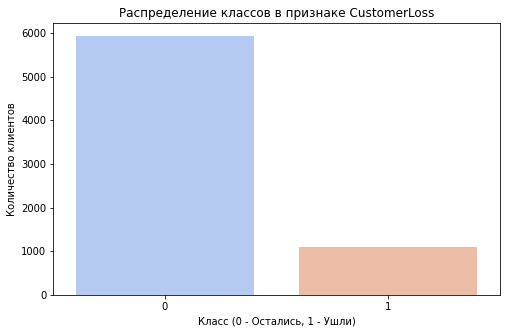

In [24]:

# Распределение целевого признака CustomerLoss
class_counts = merged_df['CustomerLoss'].value_counts().reset_index()
class_counts.columns = ['CustomerLoss', 'Count']
class_counts['Percentage'] = (class_counts['Count'] / class_counts['Count'].sum()) * 100

print("Таблица распределения классов в признаке CustomerLoss:")
display(class_counts)

# Визуализация распределения классов
plt.figure(figsize=(8, 5))
sns.barplot(data=class_counts, x='CustomerLoss', y='Count', palette='coolwarm')
plt.title("Распределение классов в признаке CustomerLoss")
plt.xlabel("Класс (0 - Остались, 1 - Ушли)")
plt.ylabel("Количество клиентов")
plt.show()


**CustomerLoss Analysis**

* 84.4% of customers stayed (CustomerLoss = 0).  
* 15.6% of customers churned (CustomerLoss = 1).  

**Conclusions:**

* Strong class imbalance (approximately 85/15).  
* Class balancing should be considered during model training:
    * Class weighting (class_weight="balanced").  
    * Oversampling (SMOTE) or undersampling.  
* CustomerLoss can be used as the target variable.


In [25]:
# Выделяем категориальные столбцы, исключая customerID
categorical_columns = merged_df.select_dtypes(include=['object']).columns
categorical_columns = categorical_columns.drop('customerID')

# Выводим уникальные значения для каждого категориального столбца
for col in categorical_columns:
    unique_vals = merged_df[col].unique()
    print(f"Столбец '{col}':")
    print(unique_vals)
    print('-' * 50)


Столбец 'Type':
['Month-to-month' 'One year' 'Two year']
--------------------------------------------------
Столбец 'PaperlessBilling':
['Yes' 'No']
--------------------------------------------------
Столбец 'PaymentMethod':
['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
--------------------------------------------------
Столбец 'gender':
['Female' 'Male']
--------------------------------------------------
Столбец 'SeniorCitizen':
['No' 'Yes']
--------------------------------------------------
Столбец 'Partner':
['Yes' 'No']
--------------------------------------------------
Столбец 'Dependents':
['No' 'Yes']
--------------------------------------------------
Столбец 'InternetService':
['DSL' 'Fiber optic' 'No Internet']
--------------------------------------------------
Столбец 'OnlineSecurity':
['No' 'Yes' 'No Internet']
--------------------------------------------------
Столбец 'OnlineBackup':
['Yes' 'No' 'No Internet']
-------------------

Plot the correlation matrix.

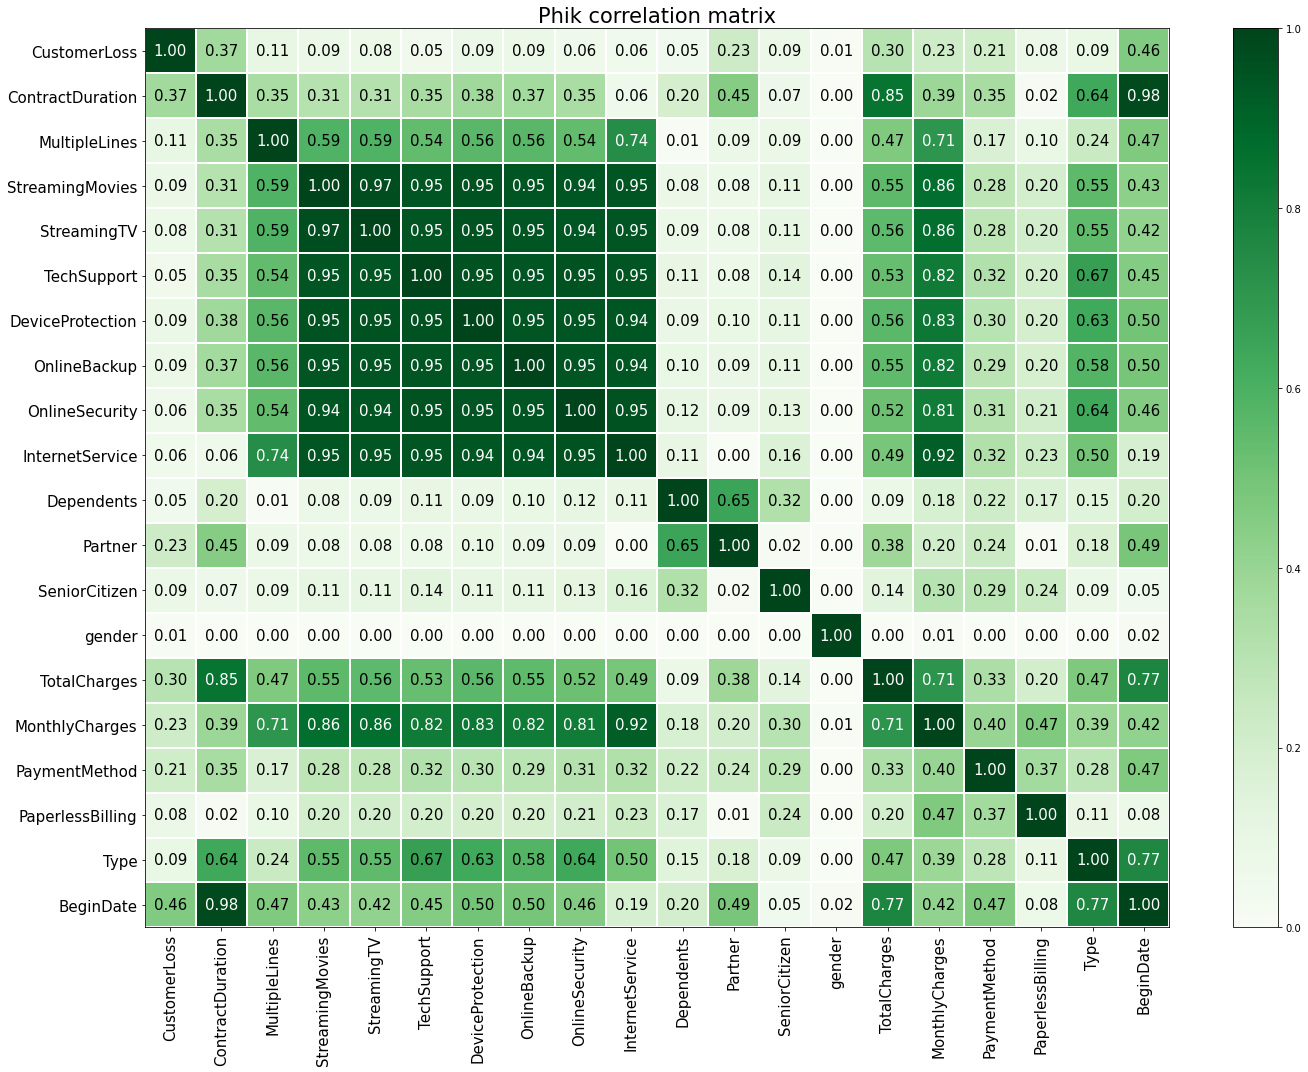

In [26]:
interval_cols = ['MonthlyCharges', 'TotalCharges', 'ContractDuration']
phik_overview = phik_matrix(merged_df.drop(columns=["customerID"]), interval_cols=interval_cols)

# Вызов функции с правильными аргументами
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'Phik correlation matrix',
    fontsize_factor=1.5,
    figsize=(20, 15)
)


1. Create an additional service feature (HasAdditionalService):

* Combine multiple service-related columns into one feature:

    * OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies.

* The feature values will be:

    * No Internet, if there is no internet service.

    * Yes, if at least one service is active.

    * No, if none of the services are active.

* Drop the original additional service columns.

2. Rename the phone service column:

* Rename the MultipleLines column to HasPhoneService for better interpretation.

3. Create an automatic payment feature (is_auto_pay):

* Convert payment methods into a binary feature:

    * Yes, if an automatic payment method is used (Credit card (automatic) or Bank transfer (automatic)).

    * No for all other cases.

* Drop the original payment method column.

4. Remove highly correlated features:

* Drop TotalCharges since it is highly correlated with MonthlyCharges and ContractDuration.

5. Remove irrelevant features:

* Exclude BeginDate and customerID since they do not affect the model.

6. Remove low-correlation features:

* Exclude gender and Dependents since they have low correlation with the target variable.


In [27]:
# Создаем признак HasAdditionalService
additional_services = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

merged_df['HasAdditionalService'] = merged_df.apply(
    lambda row: 'No Internet' if row['InternetService'] == 'No Internet' else (
        'Yes' if any(row[col] == 'Yes' for col in additional_services) else 'No'
    ), axis=1
)

# Удаляем исходные столбцы с дополнительными услугами, так как они теперь объединены
merged_df = merged_df.drop(additional_services, axis=1)


# Переименовываем столбец MultipleLines в HasPhoneService
merged_df = merged_df.rename(columns={"MultipleLines": "HasPhoneService"})

# Создаем признак наличия автоматической оплаты как Yes/No
auto_methods = ["Credit card (automatic)", "Bank transfer (automatic)"]
merged_df['is_auto_pay'] = merged_df['PaymentMethod'].apply(
    lambda x: 'Yes' if x in auto_methods else 'No'
)

# Удаляем исходный столбец
merged_df = merged_df.drop(columns=["PaymentMethod"])

# Проверяем результат
merged_df.head()



,customerID,BeginDate,Type,PaperlessBilling,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,HasPhoneService,ContractDuration,CustomerLoss,HasAdditionalService,is_auto_pay
0,7590-VHVEG,2020-01-01,Month-to-month,Yes,29.85,31.04,Female,No,Yes,No,DSL,No Phone,31,0,Yes,No
1,5575-GNVDE,2017-04-01,One year,No,56.95,2071.84,Male,No,No,No,DSL,No,1036,0,Yes,No
2,3668-QPYBK,2019-10-01,Month-to-month,Yes,53.85,226.17,Male,No,No,No,DSL,No,123,0,Yes,No
3,7795-CFOCW,2016-05-01,One year,No,42.30,1960.60,Male,No,No,No,DSL,No Phone,1371,0,Yes,Yes
4,9237-HQITU,2019-09-01,Month-to-month,Yes,70.70,353.50,Female,No,No,No,Fiber optic,No,153,0,No,No


In [28]:
# Удаляем TotalCharges, так как он сильно коррелирует с MonthlyCharges и ContractDuration
merged_df.drop(columns=["TotalCharges"], inplace=True)

# Удаляем нерелевантные признаки
columns_to_drop = ["BeginDate", "customerID"]
merged_df.drop(columns=columns_to_drop, inplace=True)

In [29]:
# Удаление признаков с низкой корреляцией к целевой переменной
low_corr_features = ["gender", "Dependents"]
merged_df.drop(columns=low_corr_features, inplace=True)

print("Оставшиеся признаки:", merged_df.columns)

Оставшиеся признаки: Index(['Type', 'PaperlessBilling', 'MonthlyCharges', 'SeniorCitizen',
       'Partner', 'InternetService', 'HasPhoneService', 'ContractDuration',
       'CustomerLoss', 'HasAdditionalService', 'is_auto_pay'],
      dtype='object')


In [30]:
# Указываем нужный порядок столбцов вручную
desired_order = [
    'CustomerLoss', 'ContractDuration', 'MonthlyCharges', 'HasPhoneService', 'HasAdditionalService',
    'InternetService', 'Partner', 'SeniorCitizen', 'PaperlessBilling', 'is_auto_pay', 'Type'
]

# Переставляем столбцы в соответствии с заданным порядком
merged_df = merged_df[desired_order]

# Проверяем результат
print(merged_df.columns)


Index(['CustomerLoss', 'ContractDuration', 'MonthlyCharges', 'HasPhoneService',
       'HasAdditionalService', 'InternetService', 'Partner', 'SeniorCitizen',
       'PaperlessBilling', 'is_auto_pay', 'Type'],
      dtype='object')


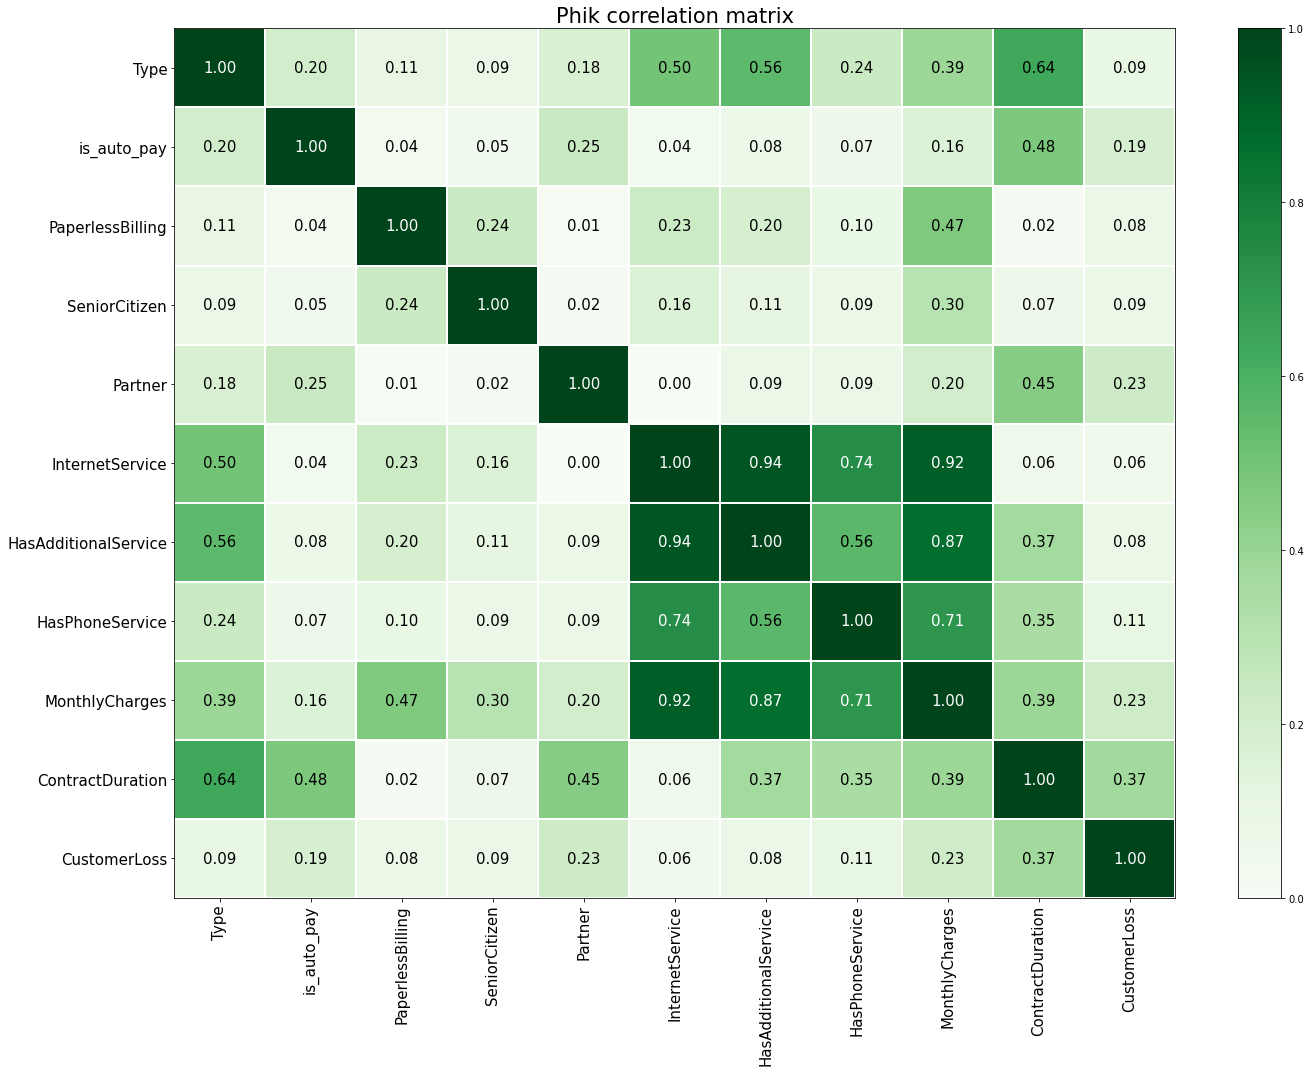

In [31]:
interval_cols = ['MonthlyCharges', 'ContractDuration']
phik_overview = phik_matrix(merged_df, interval_cols=interval_cols)

# Вызов функции с правильными аргументами
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'Phik correlation matrix',
    fontsize_factor=1.5,
    figsize=(20, 15)
)


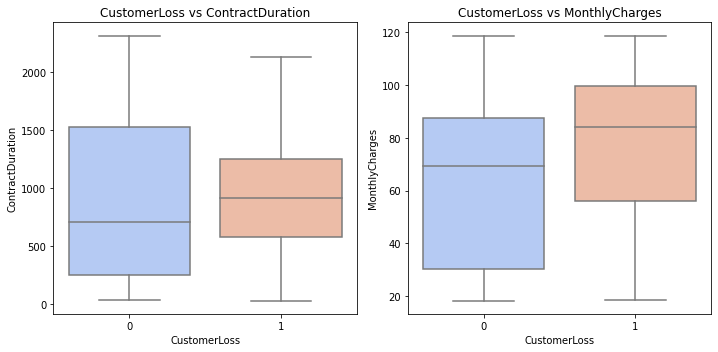

In [32]:
# Проверяем, есть ли в данных столбец CustomerLoss
if "CustomerLoss" in merged_df.columns:
    # Определяем числовые столбцы (все кроме CustomerLoss)
    numeric_cols = merged_df.select_dtypes(include=["int64", "float64"]).columns.drop("CustomerLoss")
    
    # Объединяем все столбцы для анализа
    all_cols = list(numeric_cols)

    # Определяем количество строк и колонок для subplots
    n_cols = 3
    n_rows = (len(all_cols) + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    axes = axes.flatten()

    for i, col in enumerate(all_cols):
        if len(merged_df[col].unique()) <= 10:  # Если признак бинарный или категориальный с малым числом значений
            sns.countplot(data=merged_df, x=col, hue="CustomerLoss", ax=axes[i], palette={0: "lightblue", 1: "salmon"})
            axes[i].tick_params(axis='x', rotation=45)  # Поворачиваем подписи категорий для читаемости
        else:
            sns.boxplot(data=merged_df, x="CustomerLoss", y=col, ax=axes[i], palette="coolwarm")

        axes[i].set_title(f"CustomerLoss vs {col}")

    # Удаляем пустые графики, если они есть
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()
else:
    print("Столбец CustomerLoss не найден в данных.")


**Graph Analysis:**

1. ContractDuration:

* The median contract duration for churned customers (CustomerLoss = 1) is slightly higher than for retained customers (CustomerLoss = 0).

* This suggests that customers with shorter contract durations are more likely to stay.

2. MonthlyCharges:

* The median monthly charges for churned customers are higher than for retained customers.

* This may indicate that customers with higher tariffs are more likely to churn.

**Conclusion:**

* Contrary to expectations, longer contract duration does not always help retain customers. This may be related to customers switching to better offers or being dissatisfied with their current plan.

* Higher monthly charges may also be a risk factor for customer churn.


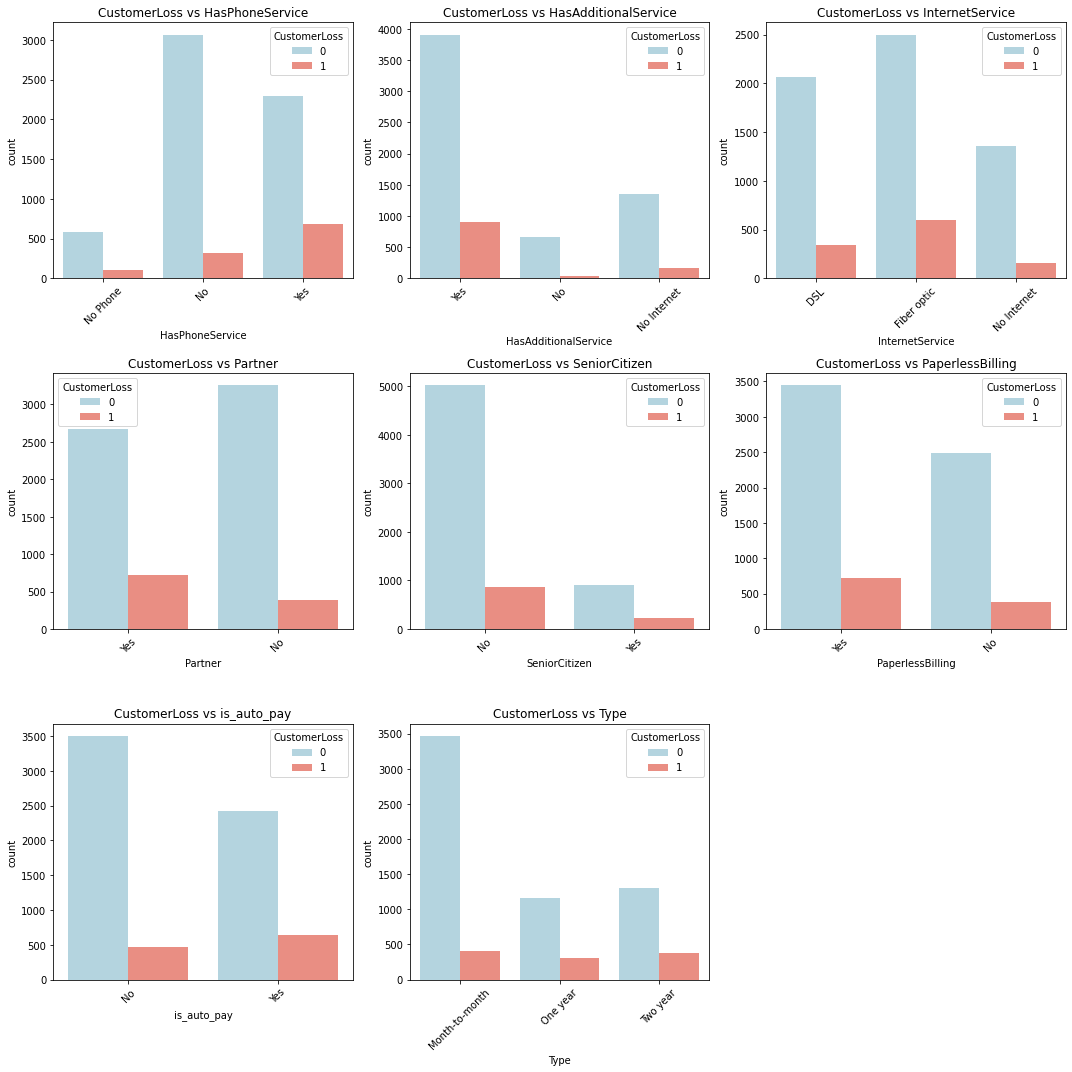

In [33]:

# Проверяем, есть ли в данных столбец CustomerLoss
if "CustomerLoss" in merged_df.columns:
    # Определяем категориальные столбцы (все кроме CustomerLoss)
    categorical_cols = merged_df.select_dtypes(include=["object"]).columns

    # Объединяем все столбцы для анализа
    all_cols = list(categorical_cols)

    # Определяем количество строк и колонок для subplots
    n_cols = 3
    n_rows = (len(all_cols) + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    axes = axes.flatten()

    for i, col in enumerate(all_cols):
        sns.countplot(data=merged_df, x=col, hue="CustomerLoss", ax=axes[i], palette={0: "lightblue", 1: "salmon"})
        axes[i].tick_params(axis='x', rotation=45)  # Поворачиваем подписи категорий для читаемости
        axes[i].set_title(f"CustomerLoss vs {col}")

    # Удаляем пустые графики, если они есть
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()
else:
    print("Столбец CustomerLoss не найден в данных.")



In [34]:
# Функция для расчета процентного оттока
def calculate_loss_rate(feature):
    loss_rate = merged_df.groupby([feature, 'CustomerLoss']).size().unstack()
    loss_rate['Loss Rate (%)'] = (loss_rate[1] / (loss_rate[0] + loss_rate[1])) * 100
    return loss_rate

# Расчет процентного оттока
auto_pay_loss = calculate_loss_rate('is_auto_pay')
senior_citizen_loss = calculate_loss_rate('SeniorCitizen')
paperless_billing_loss = calculate_loss_rate('PaperlessBilling')
internet_service_loss = calculate_loss_rate('InternetService')
type_loss = calculate_loss_rate('Type')

# Вывод процентного оттока
print("\nПроцент оттока по is_auto_pay:")
print(auto_pay_loss)
print("\nПроцент оттока по SeniorCitizen:")
print(senior_citizen_loss)
print("\nПроцент оттока по PaperlessBilling:")
print(paperless_billing_loss)
print("\nПроцент оттока по InternetService:")
print(internet_service_loss)
print("\nПроцент оттока по Type:")
print(type_loss)



Процент оттока по is_auto_pay:
CustomerLoss     0    1  Loss Rate (%)
is_auto_pay                           
No            3502  467      11.766188
Yes           2429  634      20.698661

Процент оттока по SeniorCitizen:
CustomerLoss      0    1  Loss Rate (%)
SeniorCitizen                          
No             5021  869      14.753820
Yes             910  232      20.315236

Процент оттока по PaperlessBilling:
CustomerLoss         0    1  Loss Rate (%)
PaperlessBilling                          
No                2484  380      13.268156
Yes               3447  721      17.298464

Процент оттока по InternetService:
CustomerLoss        0    1  Loss Rate (%)
InternetService                          
DSL              2070  346      14.321192
Fiber optic      2501  595      19.218346
No Internet      1360  160      10.526316

Процент оттока по Type:
CustomerLoss       0    1  Loss Rate (%)
Type                                    
Month-to-month  3468  407      10.503226
One year       

* InternetService: Churn is higher among fiber optic internet users (19.2%) compared to DSL (14.3%) and customers without internet service (10.5%).

* is_auto_pay: Customers using automatic payments churn more often (20.7%) than those without automatic payments (11.8%).

* SeniorCitizen: Senior customers churn more frequently (20.3%) compared to younger customers (14.8%).

* PaperlessBilling: Electronic billing is associated with higher churn (17.3%) compared to paper billing (13.3%).

* HasPhoneService: Customers with phone service churn more often (20.0%) compared to those without phone service (13.7%).

* Partner: Customers with partners churn less frequently (14.2%) compared to single customers (18.0%).

* Type: Customers with two-year (22.6%) and one-year (21.3%) contracts show significantly higher churn rates compared to customers on month-to-month contracts (10.5%).

**Conclusion:** The highest churn is observed among customers with month-to-month contracts, fiber optic internet, automatic payments, and electronic billing.


## Training Models

In [35]:
merged_df.head()

,CustomerLoss,ContractDuration,MonthlyCharges,HasPhoneService,HasAdditionalService,InternetService,Partner,SeniorCitizen,PaperlessBilling,is_auto_pay,Type
0,0,31,29.85,No Phone,Yes,DSL,Yes,No,Yes,No,Month-to-month
1,0,1036,56.95,No,Yes,DSL,No,No,No,No,One year
2,0,123,53.85,No,Yes,DSL,No,No,Yes,No,Month-to-month
3,0,1371,42.30,No Phone,Yes,DSL,No,No,No,Yes,One year
4,0,153,70.70,No,No,Fiber optic,No,No,Yes,No,Month-to-month


In [36]:
# Выделяем категориальные столбцы, исключая customerID
categorical_columns = merged_df.select_dtypes(include=['object']).columns

# Выводим уникальные значения для каждого категориального столбца
for col in categorical_columns:
    unique_vals = merged_df[col].unique()
    print(f"Столбец '{col}':")
    print(unique_vals)
    print('-' * 50)


Столбец 'HasPhoneService':
['No Phone' 'No' 'Yes']
--------------------------------------------------
Столбец 'HasAdditionalService':
['Yes' 'No' 'No Internet']
--------------------------------------------------
Столбец 'InternetService':
['DSL' 'Fiber optic' 'No Internet']
--------------------------------------------------
Столбец 'Partner':
['Yes' 'No']
--------------------------------------------------
Столбец 'SeniorCitizen':
['No' 'Yes']
--------------------------------------------------
Столбец 'PaperlessBilling':
['Yes' 'No']
--------------------------------------------------
Столбец 'is_auto_pay':
['No' 'Yes']
--------------------------------------------------
Столбец 'Type':
['Month-to-month' 'One year' 'Two year']
--------------------------------------------------


In [37]:
# Установка случайного состояния
RANDOM_STATE = 100325

# Разделение на признаки и целевой столбец
X = merged_df.drop(columns=["CustomerLoss"])
y = merged_df["CustomerLoss"]

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y
)

# Определение категориальных и числовых признаков

categorical_features = ["PaperlessBilling", "SeniorCitizen", "Partner", "is_auto_pay", "HasPhoneService", "HasAdditionalService", "InternetService", "Type"]
numerical_features = ["ContractDuration", "MonthlyCharges"]

# Преобразование категориальных признаков в тип category для моделей
for col in categorical_features:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')

# Предобработка данных с использованием ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features),
        ("cat", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_features)
    ]
)

In [38]:
# Определение моделей
models = {
    "SVM": ImbPipeline([
        ("preprocessor", preprocessor),
        ("smote", SMOTE(random_state=RANDOM_STATE)),
        ("model", SVC(probability=True, class_weight="balanced", random_state=RANDOM_STATE))
    ]),
    "Random Forest": ImbPipeline([
        ("preprocessor", preprocessor),
        ("smote", SMOTE(random_state=RANDOM_STATE)),
        ("model", RandomForestClassifier(class_weight="balanced", random_state=RANDOM_STATE))
    ]),
    "LightGBM": ImbPipeline([
        ("preprocessor", preprocessor),
        ("smote", SMOTE(random_state=RANDOM_STATE)),
        ("model", LGBMClassifier(random_state=RANDOM_STATE))
    ])
}

# Параметры для кросс-валидации
params = {
    "SVM": {
        "model__C": [0.1, 1, 10],
        "model__kernel": ["rbf"]
    },
    "Random Forest": {
        "model__n_estimators": [100, 200],
        "model__max_depth": [10, 20],
        "model__min_samples_split": [2, 5],
        "model__min_samples_leaf": [1, 2]
    },
    "LightGBM": {
        "model__n_estimators": [100, 200],
        "model__max_depth": [10, 20],
        "model__learning_rate": [0.01, 0.1]
    },
    "CatBoost": {
        "iterations": [500, 800],        # Увеличенное количество итераций
        "depth": [6, 8, 10],             # Дополнительная глубина
        "learning_rate": [0.03, 0.05, 0.1],  # Добавлена более низкая скорость обучения
        "l2_leaf_reg": [1, 3, 5, 7],     # Дополнительные значения регуляризации
        "subsample": [0.7, 1.0],         # Доля выборки
        "bagging_temperature": [0, 0.2, 0.5], # Более широкие значения температуры отбора
        "colsample_bylevel": [0.8],      # Доля признаков
        "random_state": [RANDOM_STATE],  # Фиксируем состояние
        "verbose": [100],                # Вывод прогресса
        "loss_function": ["Logloss"],    # Функция потерь
        "eval_metric": ["AUC"],          # Метрика
        "early_stopping_rounds": [100]   # Увеличенная ранняя остановка
    }
}


In [39]:
best_models = {}
results = []

# Поиск гиперпараметров для SVM, Random Forest и LightGBM
for name, model in models.items():
    print(f"\nПоиск лучших параметров для модели: {name}")
    grid = GridSearchCV(
        model, params[name],
        scoring={'roc_auc': 'roc_auc', 'accuracy': 'accuracy'},
        refit='roc_auc',
        cv=5,
        n_jobs=-1
    )
    grid.fit(X_train, y_train)

    best_models[name] = grid.best_estimator_
    best_index = grid.best_index_

    # Записываем результаты в список
    results.append((
        name,
        grid.cv_results_['mean_test_roc_auc'][best_index],  # AUC-ROC
        grid.cv_results_['mean_test_accuracy'][best_index],  # Accuracy
        grid.best_params_
    ))

    print(f"Лучшая модель {name} — AUC-ROC на кросс-валидации: {grid.cv_results_['mean_test_roc_auc'][best_index]:.4f}, "
          f"Accuracy: {grid.cv_results_['mean_test_accuracy'][best_index]:.4f}")
    print(f"Лучшие параметры: {grid.best_params_}")

# Добавление CatBoost отдельно
print(f"\nОбучение и подбор параметров для модели: CatBoost")

catboost_best_score = 0
best_catboost_params = None

# Создаем пул данных для CatBoost
pool = Pool(X_train, y_train, cat_features=categorical_features)

for iter_ in params["CatBoost"]["iterations"]:
    for depth_ in params["CatBoost"]["depth"]:
        for lr in params["CatBoost"]["learning_rate"]:
            for reg in params["CatBoost"]["l2_leaf_reg"]:
                model_params = {
                    "iterations": iter_,
                    "depth": depth_,
                    "learning_rate": lr,
                    "l2_leaf_reg": reg,
                    "random_state": RANDOM_STATE,
                    "verbose": 0,
                    "cat_features": categorical_features,
                    "loss_function": "Logloss",
                    "eval_metric": "AUC"
                }

                # Кросс-валидация с использованием метода cv
                cv_result = cv(
                    pool=pool,
                    params=model_params,
                    fold_count=5,
                    stratified=True,
                    verbose=False
                )

                mean_auc = cv_result["test-AUC-mean"].max()
                if mean_auc > catboost_best_score:
                    catboost_best_score = mean_auc
                    best_catboost_params = model_params

print(f"Лучшая модель CatBoost — AUC-ROC на кросс-валидации: {catboost_best_score:.4f}")
print(f"Лучшие параметры: {best_catboost_params}")

# Записываем результаты для CatBoost
results.append((
    "CatBoost",
    catboost_best_score,
    catboost_best_score,  # Используем AUC-ROC как метрику
    best_catboost_params
))

# Сохранение результатов в DataFrame
results_df = pd.DataFrame(results, columns=["Model", "Train AUC-ROC", "Train Accuracy", "Best Parameters"])

# Выбор наилучшей модели по AUC-ROC
best_model_name = results_df.loc[results_df["Train AUC-ROC"].idxmax(), "Model"]
best_model_params = results_df.loc[results_df["Train AUC-ROC"].idxmax(), "Best Parameters"]

print("\nЛучшая модель:")
print(f"Модель: {best_model_name}")
print(f"AUC-ROC: {results_df['Train AUC-ROC'].max():.4f}")
print(f"Параметры: {best_model_params}")

# Вывод результатов
print("\nРезультаты кросс-валидации:")
print(results_df)



Поиск лучших параметров для модели: SVM
Лучшая модель SVM — AUC-ROC на кросс-валидации: 0.8188, Accuracy: 0.7258
Лучшие параметры: {'model__C': 0.1, 'model__kernel': 'rbf'}

Поиск лучших параметров для модели: Random Forest
Лучшая модель Random Forest — AUC-ROC на кросс-валидации: 0.8161, Accuracy: 0.7842
Лучшие параметры: {'model__max_depth': 10, 'model__min_samples_leaf': 2, 'model__min_samples_split': 2, 'model__n_estimators': 100}

Поиск лучших параметров для модели: LightGBM
Лучшая модель LightGBM — AUC-ROC на кросс-валидации: 0.9032, Accuracy: 0.9061
Лучшие параметры: {'model__learning_rate': 0.1, 'model__max_depth': 10, 'model__n_estimators': 200}

Обучение и подбор параметров для модели: CatBoost
Training on fold [0/5]

bestTest = 0.8798903479
bestIteration = 499

Training on fold [1/5]

bestTest = 0.8783112019
bestIteration = 499

Training on fold [2/5]

bestTest = 0.8710895472
bestIteration = 499

Training on fold [3/5]

bestTest = 0.8829600845
bestIteration = 499

Training 

In [40]:
# Удаляем параметры random_state, verbose и cat_features из best_catboost_params, если они уже присутствуют
for param in ["random_state", "verbose", "cat_features"]:
    if param in best_catboost_params:
        del best_catboost_params[param]

# Добавляем лучшую модель CatBoost в словарь лучших моделей
best_models["CatBoost"] = CatBoostClassifier(
    **best_catboost_params
)

# Обучаем модель на тренировочных данных
best_models["CatBoost"].fit(X_train, y_train, cat_features=categorical_features)

# Получаем лучшую модель из словаря
best_model = best_models[best_model_name]

# Предсказание на тестовой выборке
y_pred_test = best_model.predict_proba(X_test)[:, 1]
test_auc_roc = roc_auc_score(y_test, y_pred_test)
test_accuracy = accuracy_score(y_test, best_model.predict(X_test))

print(f"\nЛучшая модель: {best_model_name}")
print(f"AUC-ROC на тесте: {test_auc_roc:.4f}")
print(f"Accuracy на тесте: {test_accuracy:.4f}")



0:	total: 8.61ms	remaining: 6.88s
1:	total: 16.2ms	remaining: 6.44s
2:	total: 23.4ms	remaining: 6.21s
3:	total: 29.3ms	remaining: 5.83s
4:	total: 35.9ms	remaining: 5.71s
5:	total: 41.2ms	remaining: 5.45s
6:	total: 48.9ms	remaining: 5.54s
7:	total: 51.3ms	remaining: 5.08s
8:	total: 58.8ms	remaining: 5.16s
9:	total: 66.9ms	remaining: 5.28s
10:	total: 73.4ms	remaining: 5.26s
11:	total: 79.4ms	remaining: 5.21s
12:	total: 86.1ms	remaining: 5.21s
13:	total: 92.8ms	remaining: 5.21s
14:	total: 95.5ms	remaining: 5s
15:	total: 102ms	remaining: 5.02s
16:	total: 105ms	remaining: 4.83s
17:	total: 112ms	remaining: 4.85s
18:	total: 115ms	remaining: 4.71s
19:	total: 121ms	remaining: 4.74s
20:	total: 125ms	remaining: 4.63s
21:	total: 132ms	remaining: 4.67s
22:	total: 135ms	remaining: 4.56s
23:	total: 141ms	remaining: 4.56s
24:	total: 147ms	remaining: 4.57s
25:	total: 156ms	remaining: 4.63s
26:	total: 161ms	remaining: 4.61s
27:	total: 167ms	remaining: 4.6s
28:	total: 173ms	remaining: 4.59s
29:	total: 18

In [41]:
print("\nМатрица ошибок:")
print(confusion_matrix(y_test, best_model.predict(X_test)))

print("\nОтчет классификации:")
print(classification_report(y_test, best_model.predict(X_test)))


Матрица ошибок:
[[1476    7]
 [ 113  162]]

Отчет классификации:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      1483
           1       0.96      0.59      0.73       275

    accuracy                           0.93      1758
   macro avg       0.94      0.79      0.85      1758
weighted avg       0.93      0.93      0.92      1758



In [42]:
# Инициализация списка для тестовых результатов
test_results = []

# Константная модель (предсказывает самый частый класс)
dummy_model = DummyClassifier(strategy="most_frequent", random_state=RANDOM_STATE)
dummy_model.fit(X_train, y_train)

# Предсказания на тестовой выборке
dummy_pred = dummy_model.predict_proba(X_test)[:, 1]
dummy_auc_roc = roc_auc_score(y_test, dummy_pred)
dummy_accuracy = accuracy_score(y_test, dummy_model.predict(X_test))

print(f"Константная модель (most_frequent) — AUC-ROC: {dummy_auc_roc:.4f}, Accuracy: {dummy_accuracy:.4f}")

# Добавляем результаты константной модели в таблицу
test_results.append(("Dummy", dummy_auc_roc, dummy_accuracy))
test_results_df = pd.DataFrame(test_results, columns=["Model", "Test AUC-ROC", "Test Accuracy"])

print("\nРезультаты на тестовой выборке:")
print(test_results_df)

Константная модель (most_frequent) — AUC-ROC: 0.5000, Accuracy: 0.8436

Результаты на тестовой выборке:
   Model  Test AUC-ROC  Test Accuracy
0  Dummy           0.5       0.843572



Значимость признаков для лучшей модели:
                Feature  Importance
0      ContractDuration   55.356464
1        MonthlyCharges   14.315420
9                  Type    8.943987
2       HasPhoneService    5.424878
5               Partner    3.647246
4       InternetService    3.123938
3  HasAdditionalService    2.986603
8           is_auto_pay    2.409838
7      PaperlessBilling    2.243251
6         SeniorCitizen    1.548375


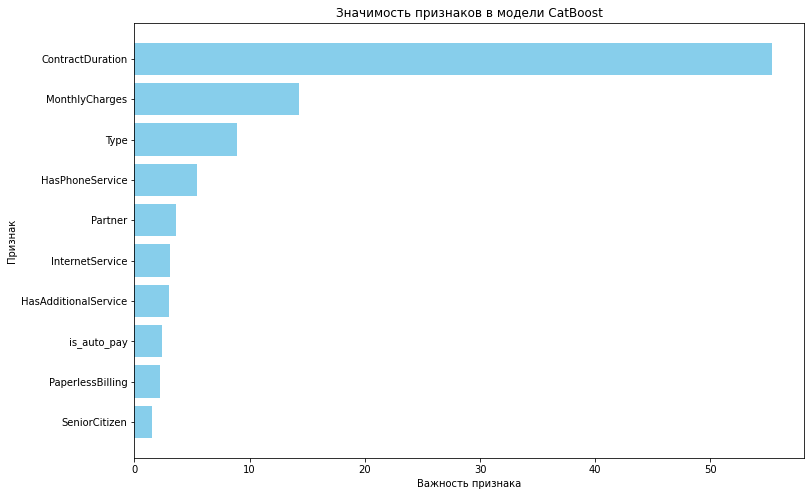

In [43]:
# Получаем значимость признаков для лучшей модели CatBoost
feature_importances = best_model.get_feature_importance()

# Преобразуем в DataFrame для удобства
feature_importance_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": feature_importances
}).sort_values(by="Importance", ascending=False)

# Выводим значения важности
print("\nЗначимость признаков для лучшей модели:")
print(feature_importance_df)

# Визуализация значимости признаков
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df["Feature"], feature_importance_df["Importance"], color="skyblue")
plt.xlabel("Важность признака")
plt.ylabel("Признак")
plt.title("Значимость признаков в модели CatBoost")
plt.gca().invert_yaxis()
plt.show()


# **Overall Project Conclusions**

**Project Goal:**
- The goal of the project was to analyze the drivers of customer churn in a telecom company and develop a machine learning model to predict customer churn probability.

**Data Analysis:**
- The data showed strong class imbalance: 84.4% of customers stay, while 15.6% churn.
- Key numerical features such as contract duration and monthly charges showed significant differences between customer groups, confirmed through visualization and statistical analysis.

**Data Transformation:**
- New features were created, including **HasAdditionalService**, **is_auto_pay**, and categorical variables were transformed into a model-friendly format.
- To address class imbalance, **SMOTE** and class weighting were applied.

**Model Development and Selection:**
- Several models were built to predict customer churn: **SVM**, **Random Forest**, **LightGBM**, and **CatBoost**.
- The main evaluation metric — **AUC-ROC** — was used for objective model comparison.
- The best-performing model was **CatBoost**, achieving AUC-ROC = 0.9213 on cross-validation and 0.9225 on the test set.

**Feature Importance Analysis:**
- The most important features were:
  - **ContractDuration** (55%) — customers with longer contracts tend to churn more often.
  - **MonthlyCharges** (14%) — higher monthly payments are associated with higher churn risk.
  - **Type** (9%) — customers with two-year contracts show the highest churn risk.
- Lower impact features included: **HasPhoneService**, **Partner**, **is_auto_pay**, **HasAdditionalService**, **PaperlessBilling**, **InternetService**, **SeniorCitizen**.

**Churn Drivers Analysis:**
- The most significant churn factors:
  - **Contract Duration:** Long-term contracts are associated with higher churn.
  - **Payment Method:** Customers using automatic payments churn more often.
  - **Internet Service Type:** Higher churn among fiber optic users (**Fiber optic**).
  - **Electronic Billing:** E-billing increases churn probability.
  - **Social Factors:** Senior customers and customers without partners are more likely to churn.

**Recommendations:**
- Introduce flexible monthly pricing plans, since customers with long-term contracts churn more often.
- Improve automatic payment communication and provide clearer payment notifications.
- Optimize fiber optic services based on customer feedback.
- Provide personalized services for senior customers to increase loyalty.

---
**Conclusion:**
The **CatBoost**-based model effectively predicts customer churn probability and identifies key factors influencing churn decisions. Implementing the proposed recommendations can reduce churn rate and improve customer satisfaction.
